In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from dataloader import CarlaDataset
from bev_new import PositionEstimation

from ipm_evaluation.fivesafe.image_tracking.track import Track

%load_ext autoreload
%autoreload 2

In [2]:
dataset = CarlaDataset.load_new_format("../datasets/camera1/")

In [3]:
position_estimator = PositionEstimation("./ipm_evaluation/conf/homography_matrix.json", 4)
print(position_estimator.Homography_Matrix)

[[ 4.20821211e+00  8.66710272e+01 -1.07882376e+04]
 [-7.29059523e+00  5.26587549e+01  3.14519167e+03]
 [-1.76501700e-05  6.48733199e-02  1.00000000e+00]]


In [4]:
position_estimator.set_homography(dataset.homography)

In [5]:
from utils import HardCodedEstimator
import joblib

with open("./regressors.joblib", "rb") as f:
    regressors = joblib.load(f)

hard_coded_estimator = regressors[-1]["classifier"]
assert isinstance(hard_coded_estimator, HardCodedEstimator)

hard_coded_estimator.set_homography(dataset.homography)

In [6]:
frame = dataset.get_frame(8)
instance = frame.vehicles[0]
image_pv = cv2.imread(str(dataset.base_path / instance.image_pv))
image_tv = cv2.imread(str(dataset.base_path / instance.image_tv))
gcp_pv = instance.gcp_pv
hull = instance.hull_pv.copy()
gcp_tv = instance.gcp_tv
track = Track(None, 2, 1, 1, 1)
hull = hull.copy()
# swap x and y coordinates
hull[:,[0,1]] = hull[:,[1,0]]
predicted_gcp_tv, _rvec, gcps_image = position_estimator.map_entity_and_return_relevant_points(track, hull)

predicted_gcp_pv = position_estimator.invert_homography(predicted_gcp_tv)
print(f"Predicted gcp_pv: {predicted_gcp_pv}, actual gcp_pv: {gcp_pv}")
print(f"Predicted gcp_tv: {predicted_gcp_tv}, actual gcp_tv: {gcp_tv}")

Predicted gcp_pv: (532.3465482663347, 268.65172410508563), actual gcp_pv: [267 525]
Predicted gcp_tv: (1046.188232421875, 799.460693359375), actual gcp_tv: [1038  823]


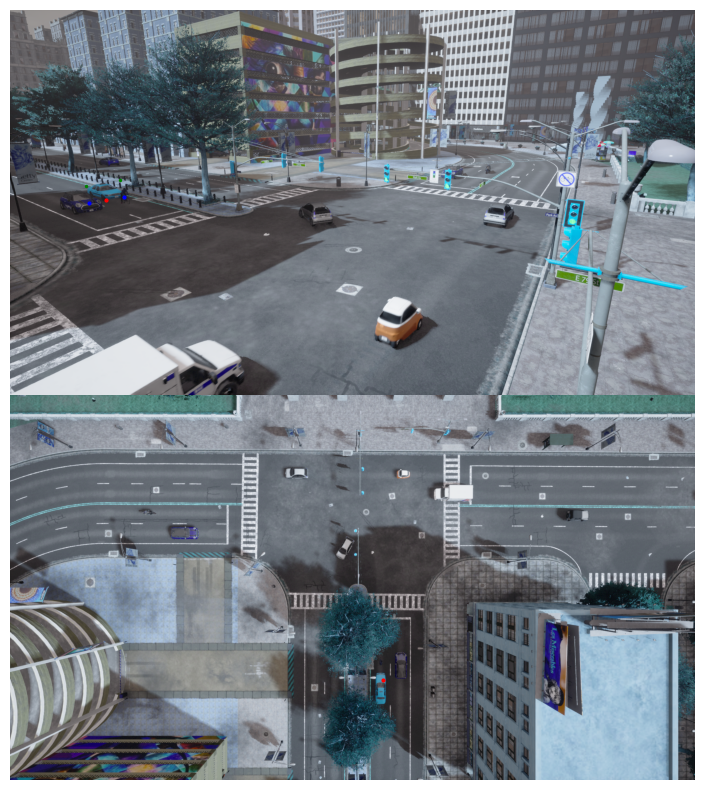

In [7]:
image_pv = image_pv.copy()
image_tv = image_tv.copy()
min_area_rect_points = position_estimator.min_rect_points

#image_pv = cv2.drawContours(image_pv, [position_estimator.min_rect_points], 0, (0, 255, 0), 2)

# create two large matplitlib figures one for each image (tv and pv)
fig, (axis_pv, axis_tv) = plt.subplots(2, 1, figsize=(10, 10))   # increase the figsize to make the figure bigger

# remove axis and use bgr color space
axis_pv.axis('off')
axis_tv.axis('off')
# remove whitespace between images
fig.subplots_adjust(hspace=0, wspace=0)
axis_pv.imshow(image_pv)
axis_tv.imshow(image_tv)

# plot predicted gcp_pv in pv
axis_pv.plot(predicted_gcp_pv[1], predicted_gcp_pv[0], 'ro', markersize=2, label='predicted gcp')
axis_pv.scatter(min_area_rect_points[:, 0], min_area_rect_points[:, 1], s=2, c='g')
# plot gcps_image 
_=axis_pv.plot(gcps_image[:, 0], gcps_image[:, 1], 'bo', markersize=2)

# plot predicted gcp in tv 
_=axis_tv.plot(predicted_gcp_tv[0], predicted_gcp_tv[1], 'ro', markersize=2)


In [8]:
frame = dataset.get_frame(8)
instance = frame.vehicles[0]
image_pv = cv2.imread(str(dataset.base_path / instance.image_pv))
image_tv = cv2.imread(str(dataset.base_path / instance.image_tv))
gcp_pv = instance.gcp_pv
hull = instance.hull_pv.copy()
gcp_tv = instance.gcp_tv
hull = hull.copy()
#swap x and y coordinates
#hull[:,[0,1]] = hull[:,[1,0]]
predicted_gcp_pv = hard_coded_estimator.predict([hull])[0]

print(f"Predicted gcp_pv: {predicted_gcp_pv}, actual gcp_pv: {gcp_pv}")

Predicted gcp_pv: [268.65172411 532.34654827], actual gcp_pv: [267 525]


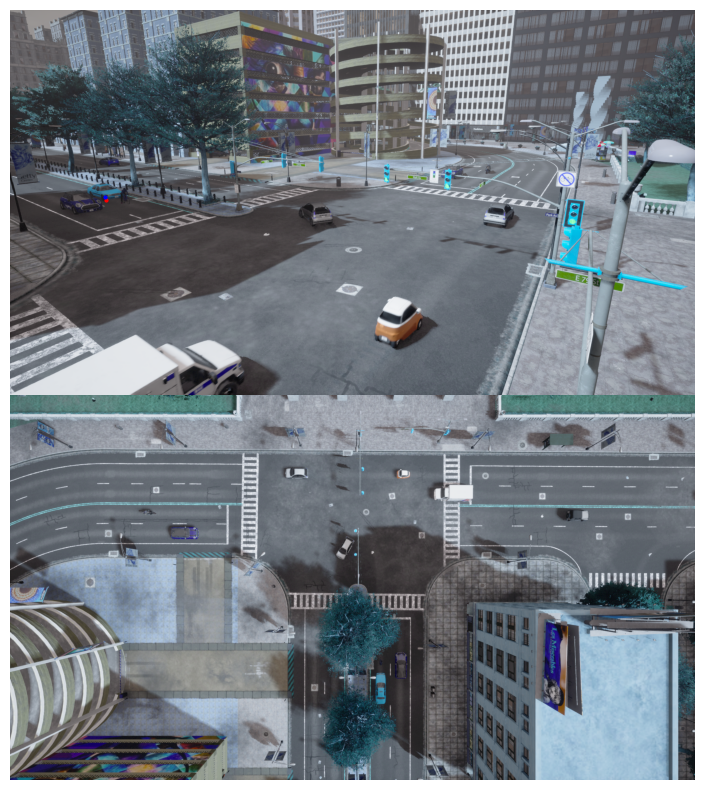

In [9]:
image_pv = image_pv.copy()
image_tv = image_tv.copy()

#image_pv = cv2.drawContours(image_pv, [position_estimator.min_rect_points], 0, (0, 255, 0), 2)

# create two large matplitlib figures one for each image (tv and pv)
fig, (axis_pv, axis_tv) = plt.subplots(2, 1, figsize=(10, 10))   # increase the figsize to make the figure bigger

# remove axis and use bgr color space
axis_pv.axis('off')
axis_tv.axis('off')
# remove whitespace between images
fig.subplots_adjust(hspace=0, wspace=0)
axis_pv.imshow(image_pv)
axis_tv.imshow(image_tv)

# plot predicted gcp_pv in pv
axis_pv.plot(predicted_gcp_pv[0], predicted_gcp_pv[1], 'ro', markersize=2, label='predicted gcp')
axis_pv.plot(gcp_pv[0], gcp_pv[1], 'bo', markersize=2, label='actual gcp')
# plot gcps_image 
#_=axis_pv.plot(gcps_image[:, 0], gcps_image[:, 1], 'bo', markersize=2)

# plot predicted gcp in tv 
#_=axis_tv.plot(predicted_gcp_tv[0], predicted_gcp_tv[1], 'ro', markersize=2)
_=plt.show()